In [1]:
import pylab as plt
from tqdm import tqdm
from pprint import pprint
from setup_libs import *

# XGBOOST

Первый алгоритм, который находится вне sklearn, так как его создавала сторонняя команда с большим числом прикольных фич.

# [Xgboost, Регуляризация](https://xgboost.readthedocs.io/en/latest/tutorials/model.html?highlight=boosting%20trees)

Проблема многих алгоритмов построения деревьев в том, что в них не уделяется должного внимания **регуляризации**. 
В классическом градиентном бустинге применяется такие меры:
- ограничение на структуру дерева: максимальная глубина (max_depth), минимальное число объектов в листе (min_samples_leaf)
- контролирование темпа обучения (learning_rate)
- увеличение "непохожести" деревьев за счет рандомизации, как в случайном лесе

[Xgboost](https://github.com/dmlc/xgboost) использует еще больше параметров для регуляризации базовых деревьев.

Бустинг строит композицию из $K$ базовых алгоритмов $b_k$:

$$ \hat{y}_i = \hat{y}_i^{K} = \sum_{k=1}^{K} b_k(x_i) = \hat{y}_i^{\left(K - 1\right)} + b_K(x_i), $$

С учетом регуляризации XGBoost минимизирует следующий функционал:

$$ Obj = \sum_{i=1}^N \mathcal{L}(y_i, \hat{y}_i ) + \sum_{k=1}^{K} \Omega(b_k),$$

где
 - $N$ — размер обучающей выборки;
 - $x_i, y_i, \hat{y}_i$ — i-ый объект, правильный ответ и предсказание модели для него;
 - $\hat{y}_i^{t}$ — предсказание композиции из $t$ уже обученных базовых алгоритмов для i-го объекта;
 - $\Omega$ — регуляризатор;
 - $\mathcal{L}(y_i, \hat{y}_i)$ — функция потерь.


Функционал, оптимизируемый на $t$-ой итерации:

$$ Obj^{(t)} = \sum_{i=1}^N \mathcal{L}\left(y_i, \hat{y}_i^{(t-1)} + b_t(x_i)\right) + \Omega(b_t).$$

В случае бустинга над **решающими деревьями** регуляризатор имеет следующий вид:

$$ \Omega(b_t) = \gamma T + \frac{1}{2}\lambda\sum_{j=1}^{T}w_j^2 + \alpha\sum_{j=1}^{T}|w_j|,$$

где 
 - $T$ — **количество листьев в дереве**;
 - $w_j$ — **веса в листьях дерева** (вероятность попадания в лист по тренировочной выборке);
 - $\lambda, \alpha, \gamma$ — **гиперпараметры**

# Пример использования Xgboost 
**Классификации на данных Iris.**

**Пример восстановления регрессии с Xgboost на данных boston.**

In [2]:
boston = pd.read_csv('data/boston.csv', sep='\t')

In [3]:
y = boston['MEDV']
features = [x for x in boston.columns if x != 'MEDV']
X = boston[features]
kf = KFold(n_splits=5, shuffle=True, random_state=17)
for train_index, test_index in kf.split(y):
    xgb_model = xgb.XGBRegressor().fit(X.iloc()[train_index],y.iloc()[train_index])
    predictions = xgb_model.predict(X.iloc()[test_index])
    actuals = y.iloc()[test_index]
    print(MSE(actuals, predictions))

9.047410100576514
8.691278284433457
15.02594228266038
7.3853090480194155
7.329729535123723


**Простой пример подбора параметров с GridSearchCV.**

In [4]:
xgb_model = xgb.XGBRegressor()
xgb_grid = GridSearchCV(xgb_model,{'max_depth': [2,4,6]}, verbose=1)
xgb_grid.fit(X,y)
print(xgb_grid.best_score_)
print(xgb_grid.best_params_)
pprint(xgb_grid.cv_results_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
0.6839859272017424
{'max_depth': 2}
{'mean_fit_time': array([0.06719947, 0.06679802, 0.08539906]),
 'mean_score_time': array([0.00440145, 0.00440049, 0.00459986]),
 'mean_test_score': array([0.68398593, 0.64637355, 0.64607696]),
 'param_max_depth': masked_array(data=[2, 4, 6],
             mask=[False, False, False],
       fill_value='?',
            dtype=object),
 'params': [{'max_depth': 2}, {'max_depth': 4}, {'max_depth': 6}],
 'rank_test_score': array([1, 2, 3]),
 'split0_test_score': array([0.81209805, 0.70314898, 0.73438184]),
 'split1_test_score': array([0.8359307 , 0.82892423, 0.84902986]),
 'split2_test_score': array([0.733587  , 0.82586137, 0.82579692]),
 'split3_test_score': array([0.53774299, 0.5595985 , 0.52374618]),
 'split4_test_score': array([0.5005709 , 0.31433465, 0.29743001]),
 'std_fit_time': array([0.02544426, 0.00359887, 0.00608607]),
 'std_score_time': array([0.00048833, 0.00049008, 0.00048944]),
 'std

## Early stopping
**Ранняя остановка используется для того, чтобы прекратить обучение модели (градиентный спуск), если ошибка за несколько итераций не уменьшилась.**

In [5]:
from sklearn.datasets import load_digits
digits = load_digits()

X = digits['data']
y = digits['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=17)
clf = xgb.XGBClassifier()
clf.fit(X_train, y_train, 
        early_stopping_rounds=10, #Ранняя остановка 
        eval_metric="merror",
        eval_set=[(X_test, y_test)])

[0]	validation_0-merror:0.14000
[1]	validation_0-merror:0.10667
[2]	validation_0-merror:0.08222
[3]	validation_0-merror:0.08000
[4]	validation_0-merror:0.06667
[5]	validation_0-merror:0.06444
[6]	validation_0-merror:0.07111
[7]	validation_0-merror:0.07111
[8]	validation_0-merror:0.06889
[9]	validation_0-merror:0.06667
[10]	validation_0-merror:0.06444
[11]	validation_0-merror:0.06667
[12]	validation_0-merror:0.06889
[13]	validation_0-merror:0.06000
[14]	validation_0-merror:0.05778
[15]	validation_0-merror:0.06222


c:\Users\alexandr.pankratov\Anaconda3\envs\ml_cource\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\alexandr.pankratov\Anaconda3\envs\ml_cource\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[16]	validation_0-merror:0.06000
[17]	validation_0-merror:0.05778
[18]	validation_0-merror:0.05556
[19]	validation_0-merror:0.05333
[20]	validation_0-merror:0.05556
[21]	validation_0-merror:0.05556
[22]	validation_0-merror:0.04889
[23]	validation_0-merror:0.04889
[24]	validation_0-merror:0.05111
[25]	validation_0-merror:0.05333
[26]	validation_0-merror:0.05111
[27]	validation_0-merror:0.04889
[28]	validation_0-merror:0.04889
[29]	validation_0-merror:0.04667
[30]	validation_0-merror:0.04667
[31]	validation_0-merror:0.04444
[32]	validation_0-merror:0.04667
[33]	validation_0-merror:0.04444
[34]	validation_0-merror:0.04444
[35]	validation_0-merror:0.04222
[36]	validation_0-merror:0.04000
[37]	validation_0-merror:0.04000
[38]	validation_0-merror:0.04000
[39]	validation_0-merror:0.03778
[40]	validation_0-merror:0.04000
[41]	validation_0-merror:0.04000
[42]	validation_0-merror:0.03778
[43]	validation_0-merror:0.03778
[44]	validation_0-merror:0.03778
[45]	validation_0-merror:0.03778
[46]	valid

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

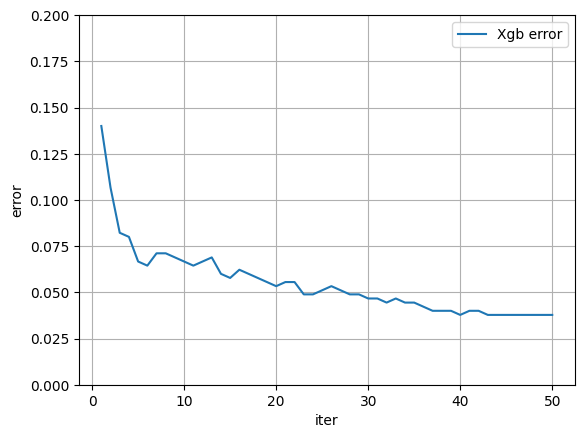

In [6]:
errors_by_iter = clf.evals_result()['validation_0']['merror']
plt.plot(range(1, len(errors_by_iter) + 1), errors_by_iter, label='Xgb error')
plt.xlabel('iter')
plt.ylabel('error')
plt.ylim(0, 0.2)
plt.legend()
plt.grid()

# [Параметры XGBoost](https://xgboost.readthedocs.io/en/latest/parameter.html)

Более развернутую информацию можно найти в файле parametrs.txt и на [сайте](https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/)

Выделяют три группы параметров:
- Общие параметры, отвечающие за базовый алгоритм для бустинга и распараллеливание.
- Параметры выбранного базового алгоритма.
- Параметры обучения, отвечающие за функцию потерь и метрику качества на валидации.

**1. Общие параметры:**
- booster [default=gbtree] - тип базового алгоритма для бустинга: **дерево решений** gbtree или **линейная модель** gblinear. 
- nthread [default to maximum number of threads available if not set] - число нитей доступных для параллельной работы xgboost.

**2. Параметры базового алгоритма:**

**2.1. Дерево решений:**
Параметры как в стандартном дереве решений: `eta`, `gamma`, `max_depth`, `min_child_weight`, `max_delta_step`, `subsample` и.т.д.

**2.2. Линейная модель:**
- lambda [default=0] - коэффициент перед $L_2$-регуляризатором вектора весов в функции потерь.
- alpha [default=0] - коэффициент перед $L_1$-регуляризатором вектора весов в функции потерь.
- lambda_bias [default=0] - коэффициент перед $L_2$-регуляризатором смещения (свободного члена) в функции потерь.

**3. Параметры задачи обучения:**
- **objective** [default=reg:linear] - используемая при обучении функция потерь:
    * `reg:linear`, `reg:logistic`, `binary:logistic`, `binary:logitraw`, `count:poisson`, `multi:softmax`, `multi:softprob`, `rank:pairwise`
- **base_score** [default=0.5] - инициализация значения модели для всех примеров, глобальное смещение.
- **eval_metric** [default according to objective] - метрика качества на валидационной выборке (по умолчанию соответствует функции потерь: rmse - для регрессии, error - для классификации, mean average precision - для ранжирования). Выбрать можно одну из следующих метрик:
    - `rmse`, `logloss`, `error`, `merror`, `mlogloss`, `auc`, `ndcg`, `map` и.т.д.
- **seed** [default=0] - для воспроизводимости "случайности".


## Сравнение алгоритмов по времени работы

Посмотрим на время обучения классификаторов XGBooster и GradientBoostingClassifier. Для этого будем генерировать выборку из 1000 объектов и 50 признаков с помощью sklearn.datasets.make_classification и замерять время обучения.

In [7]:
from tqdm.notebook import tqdm
import time

xgb_params1 = {'booster': 'gbtree', 
               'n_estimators': 100, 
               'max_depth': 3, 
               'eta': 0.1,
               'objective': 'binary:logistic', 
               'nthread': 1}

xgb_params2 = {'booster': 'gbtree', 
               'n_estimators': 100, 
               'max_depth': 3, 
               'eta': 0.1,
               'objective': 'binary:logistic', 
               'nthread': 4}

sklearn_params = {'n_estimators': 100, 'max_depth': 3}

xgb_time1 = list()
xgb_time2 = list()
sklearn_time = list()

n_runs = 50

for i in tqdm(range(n_runs)):
    # Generating dataset
    X, y = make_classification(n_samples=1000, n_features=50, n_informative=20)
    # Training XGBooster (nthread=1)
    t = time.time()
    bst = xgb.XGBClassifier(**xgb_params1).fit(X, y)
    elapsed = time.time() - t
    xgb_time1.append(elapsed)
    # Training XGBooster (nthread=4)
    t = time.time()
    bst = xgb.XGBClassifier(**xgb_params2).fit(X, y)
    elapsed = time.time() - t
    xgb_time2.append(elapsed)
    # Training GradientBoostingClassifier
    t = time.time()
    clf = GradientBoostingClassifier(**sklearn_params).fit(X, y)
    elapsed = time.time() - t
    sklearn_time.append(elapsed)

  0%|          | 0/50 [00:00<?, ?it/s]

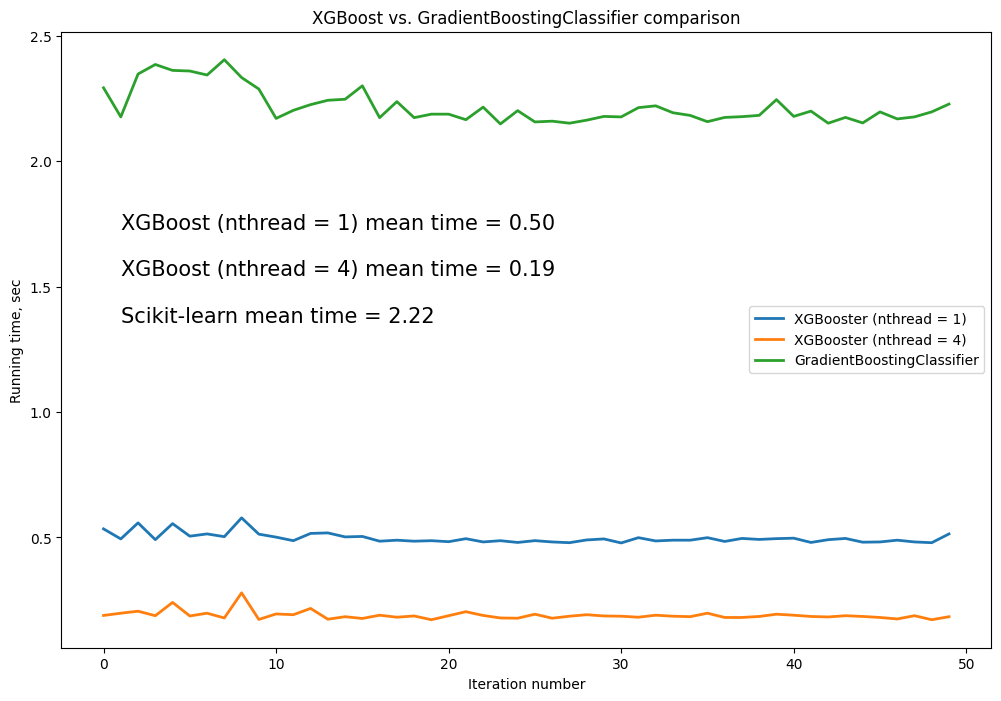

In [9]:
%matplotlib  inline
import matplotlib.pyplot as plt

xgb_mean1 = sum(xgb_time1) / n_runs
xgb_mean2 = sum(xgb_time2) / n_runs
sklearn_mean = sum(sklearn_time) / n_runs

plt.figure(figsize=(12, 8))
plt.plot(xgb_time1, label='XGBooster (nthread = 1)', lw=2)
plt.plot(xgb_time2, label='XGBooster (nthread = 4)', lw=2)
plt.plot(sklearn_time, label='GradientBoostingClassifier', lw=2)
plt.legend(loc='best')
plt.text(1, (xgb_mean1 + sklearn_mean) / 2, 
         'XGBoost (nthread = 1) mean time = %.2f' % xgb_mean1 +
         '\n\nXGBoost (nthread = 4) mean time = %.2f' % xgb_mean2 +
         '\n\nScikit-learn mean time = %.2f' % sklearn_mean,
            fontsize = 15)
plt.xlabel('Iteration number')
plt.ylabel('Running time, sec')
plt.title('XGBoost vs. GradientBoostingClassifier comparison')
plt.show()

## Выводы

Основные преимущества XGBoost по сравнению с sklearn.ensembles.GradientBoostingClassifier:
- Помимо деревьев возможно использование линейных моделей в качестве базовых классификаторов.
- Скорость работы.
- Возможность распараллеливания.
- Значительно больший выбор стандартных функций потерь, а также возможность задавать свою функцию потерь.
- Наличие регуляризаторов в итоговой функции потерь и возможность задавать их коэффициенты, что даёт еще один метод борьбы с переобучением, помимо использования случайности (subsample, colsample_bytree) и основных параметров дерева решений.
- Встроенная обработка missing values.

# Feature Importance

### Важность признаков

**F score при оценке важности признаков в Xgboost (не путать с F1 score как метрики качества классификации) вычисляется на основе того, как часто разбиение делалось по данному признаку.**

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

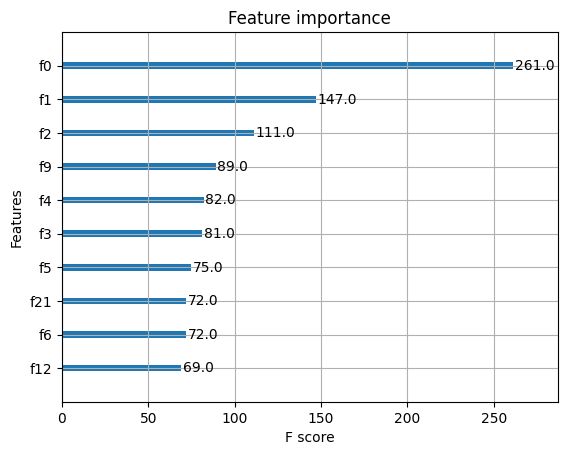

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y)
xgb_model = xgb.XGBRegressor().fit(X_train,y_train)
xgb.plot_importance(xgb_model, max_num_features=10)

Или так

In [13]:
xgb_model.feature_importances_

array([0.00901915, 0.0091657 , 0.00848289, 0.00735221, 0.00608905,
       0.0041211 , 0.00265438, 0.00462857, 0.04155416, 0.05190875,
       0.01040358, 0.00976121, 0.01359327, 0.01686761, 0.01553666,
       0.01108246, 0.0019262 , 0.08253706, 0.15199415, 0.00869855,
       0.09982374, 0.00214325, 0.01553215, 0.02732917, 0.00716103,
       0.00958363, 0.00427125, 0.00887087, 0.00849447, 0.00281886,
       0.00367621, 0.00167336, 0.00785463, 0.02810586, 0.00903001,
       0.00630448, 0.06632343, 0.00078747, 0.06143983, 0.01013208,
       0.00936472, 0.00567689, 0.01689697, 0.01046986, 0.00516303,
       0.00223348, 0.02878651, 0.00243519, 0.00280281, 0.06743804],
      dtype=float32)

## Полезные ссылки
- <a href="https://en.wikipedia.org/wiki/Boosting_(machine_learning)">Boosting Wikipedia</a>
- [Gradient boosting. Wikipedia](https://en.wikipedia.org/wiki/Gradient_boosting)
- [Лекция Слайды Воронцова 2018г](http://www.machinelearning.ru/wiki/images/c/cd/Voron-ML-Compositions-slides.pdf) К.В. Воронцова по композиционным методам классификации
- <a href="https://github.com/dmlc/xgboost">Github Xgboost</a>
- <a href="https://github.com/ChenglongChen/Kaggle_CrowdFlower">Обзор</a> решения победителя соревнования Kaggle "CrowdFlower" по предсказанию релевантности выдачи поисковика товаров. Решение на основе Xgboost

- [XGBoost doc](https://xgboost.readthedocs.org/en/latest/parameter.html)
- [GradientBoostingClassifier. Sklearn doc](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html)
- [Сравнение](https://github.com/szilard/benchm-ml) различных библиотек для машинного обучения, в том числе sklearn и xgboost 